# Digit Recognizer


## Aim

### Take an image of a handwritten single digit, and determine what that digit is.

## Metrics

### This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

## Descirption of Dataset

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

# коэффициент скорости обучения
LEARNING_RATE = 1e-4 

# кол-во итераций
TRAINING_ITERATIONS = 2500        

# Dropout - это метод регуляризации для уменьшения переобучения в нейронных сетях.
# Основная идея: вместо изучения одной сети обучать ансамбль из нескольких сетей, а затем усреднять полученные результаты.

DROPOUT = 0.5
BATCH_SIZE = 50

VALIDATION_SIZE = 2000

# изображение для отображения
IMAGE_TO_DISPLAY = 10

C:\Users\ilya\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
data = pd.read_csv('../input/train.csv')

print('data({0[0]},{0[1]})'.format(data.shape))
print (data.head())

data(42000,785)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8    ...     pixel774  pixel775  pixel776  pixel777  pixel778  \
0       0    ...            0         0         0         0         0   
1       0    ...            0         0         0         0         0   
2       0    ...            0         0         0         0         0   
3       0    ...            0         0         0         0         0   
4       0    ...            0         0         0         0         0   

   pixel779  pixel780  pixel781  pixel782  pixel783  
0         0         0         0   

In [4]:
images = data.iloc[:,1:].values
images = images.astype(np.float)

# конвертирую из [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [5]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# все изображения - квадраты
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


Чтобы вывести одно из изображений, преобразую эту длинную строку пикселей в 2-мерный массив, который в основном представляет собой изображение в градациях серого.

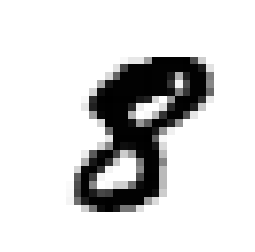

In [6]:
# отображаю изображение
def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
     
display(images[IMAGE_TO_DISPLAY])

Соответствующие метки представляют собой числа от 0 до 9, описывающие, какой цифрой является данное изображение.

In [9]:
labels_flat = data.iloc[:,0].values

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


В этом случае существует десять различных цифр / меток / классов.

In [10]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


Для большинства задач классификации используются «one-hot vectors». Это вектор, который содержит один элемент, равный 1, а остальные элементы равны 0.

In [11]:
# конвертирую метки классов из скаляров в one-hot vectores
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [12]:
# разделяю данные на обучение и валидацию
validation_images = images[:VALIDATION_SIZE]
validation_labels = labels[:VALIDATION_SIZE]

train_images = images[VALIDATION_SIZE:]
train_labels = labels[VALIDATION_SIZE:]

print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(40000,784)
validation_images(2000,784)


## TensorFlow граф

Использую функцию активации Relu

Функция активации — это способ нормализации входных данных. То есть, если на входе у вас будет большое число, пропустив его через функцию активации, вы получите выход в нужном вам диапазоне.

В последние годы большую популярность приобрела функция активации под названием «выпрямитель». Нейроны с данной функцией активации называются ReLU (rectified linear unit). ReLU имеет следующую формулу *f(x)=max(0,x)* и реализует простой пороговый переход в нуле.

Положительные стороны:

Вычисление сигмоиды и гиперболического тангенса требует выполнения ресурсоемких операций, таких как возведение в степень, в то время как ReLU может быть реализован с помощью простого порогового преобразования матрицы активаций в нуле. Кроме того, ReLU не подвержен насыщению.
Применение ReLU существенно повышает скорость сходимости стохастического градиентного спуска (в некоторых случаях до 6 раз [Krizhevsky et al.]) по сравнению с сигмоидой и гиперболическим тангенсом. Считается, что это обусловлено линейным характером и отсутствием насыщения данной функции.
Отрицательные стороны:

К сожалению, ReLU не всегда достаточно надежны и в процессе обучения могут выходить из строя («умирать»). Например, большой градиент, проходящий через ReLU, может привести к такому обновлению весов, что данный нейрон никогда больше не активируется. Если это произойдет, то, начиная с данного момента, градиент, проходящий через этот нейрон, всегда будет равен нулю. Соответственно, данный нейрон будет необратимо выведен из строя. Например, при слишком большой скорости обучения (learning rate), может оказаться, что до 40% ReLU «мертвы» (то есть, никогда не активируются). Эта проблема решается посредством выбора надлежащей скорости обучения.


In [13]:
# инициализация весов и смещений
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

Для этой проблемы использую заполнение отступов нулями (zero paded convolutions), чтобы размер выходного файла был таким же, как у входного значения. Шаг (stride) в этом случае равен 1.
В общем, слой свертки используется для получения признаков. В случае распознавания цифр - форма каждой цифры. Он использует доступные для изучения ядра / фильтры, каждое из которых соответствует одному конкретному шаблону формы. 


In [14]:
# свертывание
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Max pooling - 2x2.

Max pooling используется для понижения выборки данных. Max pooling 2x2 разбивает изображение на квадратные 2-пиксельные блоки и сохраняет только максимальное значение для каждого из этих блоков.

In [15]:
# пулинг
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Любой NN может использоваться как слой в большом многослойном NN, а это означает, что выход одного можно использовать как вход для другого. Этот последовательный подход может создать очень сложную NN с несколькими уровнями. Их также называют глубокими нейронными сетями.

В этом случае использую два слоя свертки с пулингом между ними, затем полносвязный слой с dropout и слой считывания (Readout layer: Softmax Layer)

Полносвязные слои соединяют каждый нейрон в одном слое с каждым нейроном в другом слое. Это в принципе то же самое, что и традиционная многослойная нейронная сеть перцептрона (MLP). Этот слой берёт вводные данные и выводит N-пространственный вектор, где N — число классов, из которых программа выбирает нужный. Например, если вы хотите программу по распознаванию цифр, у N будет значение 10, потому что цифр 10. 

In [16]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

Patch - это окно с определенным кол-ом пикселей, которое проходит по всему изображению во время свертки.

Первый слой - это свертка, за которой следует макс пулинг. Свертка вычисляет 32 признака для каждого патча 5x5. Его весовой тензор имеет форму [5, 5, 1, 32]. Первые два измерения - это размер патча, следующее - количество входных каналов (1 означает, что изображения в оттенках серого), а последнее - количество выходных каналов. Существует также вектор смещения с компонентом для каждого выходного канала.

Чтобы применить слой, преобразую входные данные в тензор 4d, причем первое измерение соответствует количеству изображений, второе и третье - ширине и высоте изображения, а окончательное измерение - количеству цветовых каналов.

После свертки пул уменьшает размер вывода с 28x28 до 14x14.

In [17]:
# первый сверточный слой
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(40000,28,28,1)

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (40000, 14, 14, 32)

# подготовка для визуализации 32 признаков в сетке 4 на 8
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))
layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8)) 

Второй слой имеет 64 признака для каждого патча 5х5. Его весовой тензор имеет форму [5, 5, 32, 64]. Первые два измерения - это размер патча, следующее - количество входных каналов (32 канала соответствуют 32 признакам, которые я получилиз предыдущего сверточного слоя), а последнее - количество выходных каналов. Существует также вектор смещения с компонентом для каждого выходного канала.

Поскольку изображение подвергается понижающей дискретизации путем объединения до размера 14x14, второй сверточный слой получает более общие признаки изображений. Фильтры занимают больше места на картинке. Таким образом, он настроен на более общие признаки, в то время как первый слой находит мелкие детали.

In [18]:
# второй сверточный слой
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# для визуализации 64 признаков в сетке 4 на 16
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))
layer2 = tf.reshape(layer2, (-1, 14*4, 14*16)) 

Теперь, когда размер изображения уменьшен до 7x7, добавляю полносвязный слой с 1024 нейронами, чтобы совершить обработку всего изображения (каждый из нейронов полносвязного слоя связан со всеми активациями / выходами предыдущего слоя)

In [19]:
# полносвязный слой
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
#print (h_fc1.get_shape()) # => (40000, 1024)

Чтобы предотвратить переобучение, применяю dropout перед слоем считывания.

Dropout удаляет некоторые узлы из сети на каждом этапе обучения. Каждый из узлов либо хранится в сети с вероятностью *keep_prob *, либо отбрасывается с вероятностью *1 - keep_prob*. После завершения этапа обучения узлы возвращаются в NN с их исходными весами.

In [20]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Наконец, добавляю слой softmax

In [21]:
# слой считывания для глубокой сети
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

#print (y.get_shape()) # => (40000, 10)

Для оценки производительности сети я использую кросс-энтропию, а для ее минимизации используется оптимизатор ADAM.

Оптимизатор ADAM - это алгоритм оптимизации на основе градиента, основанный на адаптивных оценках, он более сложен, чем наибольший градиентный спуск, и хорошо подходит для задач с большим кол-ов данных или многими параметрами.

In [22]:
# функция потерь
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


# функция оптимизации
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# оценка
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

Чтобы предсказать значения из валидационных данных, наибольшая вероятность выбирается из "one-hot vector", что указывает на то, что шансы изображения быть одной из цифр являются самыми высокими.

In [23]:
# функция предсказаний
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

*Наконец, структура нейронной сети определена, и TensorFlow граф готов к обучению.*
## Тренировка и предсказания

В идеале, я должен использовать все данные для каждого этапа обучения, но это ресурсозатратно. Таким образом, вместо этого я использую небольшие батчи (batches) случайных данных.

Этот метод называется стохастическим обучением. Это быстрее и дает тот же результат.

In [24]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_images.shape[0]

def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # когда все тренировочные данные уже использованы, они переупорядочиваются случайным образом  
    if index_in_epoch > num_examples:
        # законченная эпоха
        epochs_completed += 1
        # перемешать данне
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # начать следующую эпоху
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

Теперь, когда все операции для каждой переменной определены в графе TensorFlow, все вычисления будут выполняться вне среды Python.

In [25]:
# начать сессию TensorFlow
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()

sess.run(init)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


На каждом этапе цикла я получаю батч точек данных из обучающего набора и подаем его на граф для замены плэйсхолдеров. В данном случае это: *x, y* и *dropout.*

Кроме того, время от времени я проверяю точность обучения на предстоящем батче.

В локальной среде рекомендуется сохранить прогресс в обучении, чтобы его можно было восстановить для дальнейшего обучения, отладки или оценки.

In [27]:
# переменные визуализации
train_accuracies = []
validation_accuracies = []
x_range = []

display_step=1

for i in range(TRAINING_ITERATIONS):

    #получить новый батч
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # проверять прогресс на каждом 1ом,2ом,...,10ом,20ом,...,100ом... шаге
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE], 
                                                            keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # увеличить display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # тренировка на батчах
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.94 / 0.94 for step 0
training_accuracy / validation_accuracy => 0.98 / 0.94 for step 1
training_accuracy / validation_accuracy => 0.96 / 0.94 for step 2
training_accuracy / validation_accuracy => 0.92 / 0.94 for step 3
training_accuracy / validation_accuracy => 0.94 / 0.94 for step 4
training_accuracy / validation_accuracy => 0.90 / 0.94 for step 5
training_accuracy / validation_accuracy => 0.96 / 0.94 for step 6
training_accuracy / validation_accuracy => 0.90 / 0.94 for step 7
training_accuracy / validation_accuracy => 0.88 / 0.94 for step 8
training_accuracy / validation_accuracy => 0.94 / 0.94 for step 9
training_accuracy / validation_accuracy => 0.98 / 0.94 for step 10
training_accuracy / validation_accuracy => 0.98 / 0.94 for step 20
training_accuracy / validation_accuracy => 0.96 / 0.94 for step 30
training_accuracy / validation_accuracy => 0.88 / 0.96 for step 40
training_accuracy / validation_accuracy => 0.94 / 0.96 for step 50
train

После того, как обучение закончено, хорошо проверить точность данных, которые не использовались в обучении.

validation_accuracy => 0.9835


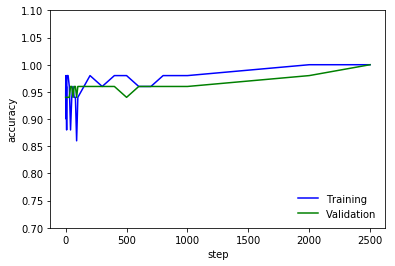

In [28]:
# проверить окончательную точность на валидации
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: validation_images, 
                                                   y_: validation_labels, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

Когда мы довольны результатом, мы читаем тестовые данные из *test.csv* и прогнозируем метки для предоставленных изображений.

Тестовые данные содержат только изображения и метки отсутствуют. В остальном структура аналогична обучающим данным.

Предсказанные метки сохраняются в файле CSV для последующей отправки.

test_images(28000,784)
predicted_lables(28000)
predicted_lables[10] => 5.0


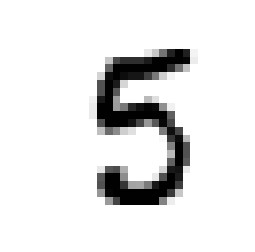

In [29]:
# читаю тестовые данные из файла CSV
test_images = pd.read_csv('../input/test.csv').values
test_images = test_images.astype(np.float)

# конвертирую из [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# предсказываю тестовый набор данных
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# использование батчей более ресурсоэффективно
predicted_lables = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_lables[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_lables({0})'.format(len(predicted_lables)))

# выходное тестовое изображение и прогноз
display(test_images[IMAGE_TO_DISPLAY])
print ('predicted_lables[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_lables[IMAGE_TO_DISPLAY]))

# сохраняю результаты
np.savetxt('submission_softmax.csv', 
           np.c_[range(1,len(test_images)+1),predicted_lables], 
           delimiter=',', 
           header = 'ImageId,Label', 
           comments = '', 
           fmt='%d')

Полезно было бы вывести некоторые переменные для лучшего понимания процесса.

Здесь можно увидеть вывод первого слоя свертки из графа TensorFlow. 32 объекта преобразованы в сетку изображений, и довольно интересно посмотреть, как фильтры, выбранные по NN, описывают характеристики различных цифр.

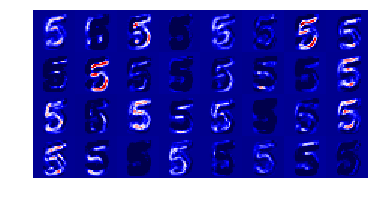

In [30]:
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )

In [31]:
sess.close()